In [1]:
# !pip install gym[box2d]

## Automatisation der Environment LunarLander durch Reinforcement Learning (DQN)

Das nachfolgende Notebook wurde auf Grundlage von [dieser Lösung](https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html) - "Deep Q-Network (DQN) on LunarLander-v2" Chanseok Kang erstellt.

### 1. Import der benötigten Bibliotheken

In [2]:
# Importieren der benötigten Pakete
import gym
import torch
import random
import glob
import base64
import io

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque, namedtuple
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from tqdm import tqdm

### 2. Torch-Device definieren

In [3]:
# Überprüfen der verfügbaren GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 3. Hyperparameter definieren

In [4]:
# Hyperparameter
BUFFER_SIZE = int(1e5)  # Buffer Größe für Replay Memory
BATCH_SIZE = 64  # Batch Größe zum Trainieren
GAMMA = 0.99  # Gewöhnungsfaktor
TAU = 1e-3  # Soft-Update Faktor
LR = 5e-4  # Lernrate
UPDATE_EVERY = 4  # wie oft die Parameter updated werden

### 4. Environment definieren

In [5]:
# Environment definieren
env = gym.make('LunarLander-v2')

#### 4.1. Environment Details

In [6]:
# Environment Details
print('State Space: ', env.observation_space)
print('State Space Größe: ', env.observation_space.shape[0])
print('Aktion Space: ', env.action_space)
print('Aktion Space Größe: ', env.action_space.n)

State Space:  Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
State Space Größe:  8
Aktion Space:  Discrete(4)
Aktion Space Größe:  4


### Definition des QNets

In [7]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """
        Initialisierung der Parameter und Erstellung des Modells.
        :param state_size: Dimension des Zustandsraums
        :param action_size: Dimension des Aktionsraums
        :param seed: Random Seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)  # Setzen des Seeds für Reproduzierbarkeit
        self.fc1 = nn.Linear(state_size, 64)  # Erstellen des ersten Layers
        self.fc2 = nn.Linear(64, 64)  # Erstellen des zweiten Layers
        self.fc3 = nn.Linear(64, action_size)  # Erstellen des dritten Layers

    def forward(self, state):
        """
        Vorwärts propagierung des Zustands durch das Netzwerk.
        :param state: Zustand
        :return:
        """
        x = self.fc1(state)  # Vorwärts propagierung durch den ersten Layer
        x = F.relu(x)  # Aktivierungsfunktion
        x = self.fc2(x)  # Vorwärts propagierung durch den zweiten Layer
        x = F.relu(x)  # Aktivierungsfunktion
        return self.fc3(x)  # Vorwärts propagierung durch den dritten Layer

### Defitition des Buffers

In [8]:
class ReplayBuffer:
    """
    Speichert Erfahrungen und gibt zufällige Samples zurück.
    """

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initialisierung der Parameter und Erstellung des Buffers.
        :param action_size: Dimension des Aktionsraums
        :param buffer_size: Größe des Buffers
        :param batch_size: Größe des Batches
        :param seed: Random Seed
        """
        self.action_size = action_size  # Dimension des Aktionsraums
        self.memory = deque(maxlen=buffer_size)  # Erstellen des Buffers
        self.batch_size = batch_size  # Größe des Batches
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state",
                                                                "done"])  # Erstellen der Erfahrung
        self.seed = random.seed(seed)  # Setzen des Seeds für Reproduzierbarkeit

    def add(self, state, action, reward, next_state, done):
        """
        Hinzufügen einer Erfahrung zum Buffer.
        :param state: Wie ist der Zustand?
        :param action:  Welche Aktion wurde ausgeführt?
        :param reward: Was ist die Belohnung?
        :param next_state: Was ist der nächste Zustand?
        :param done: Ist das Spiel beendet?
        :return:
        """
        e = self.experience(state, action, reward, next_state, done)  # Erstellen der Erfahrung
        self.memory.append(e)  # Hinzufügen der Erfahrung zum Buffer

    def sample(self) -> tuple:
        """
        Zufälliges Sample aus dem Buffer.
        :return: Zufälliges Sample aus dem Buffer
        """
        experiences = random.sample(self.memory, k=self.batch_size)  # Zufälliges Sample aus dem Buffer

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(
            device)  # Zustände
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(
            device)  # Aktionen
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(
            device)  # Belohnungen
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)  # Nächste Zustände
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)  # Ist das Spiel beendet?

        return (states, actions, rewards, next_states, dones)  # Rückgabe der Erfahrungen

    def __len__(self) -> int:
        """
        Länge des Buffers.
        :return: Länge des Buffers
        """
        return len(self.memory)

### Definition des Agenten

In [9]:
class Agent:
    """
    Interagiert mit der Umgebung und lernt daraus.
    """

    def __init__(self, state_size, action_size, seed):
        """
        Initialisierung der Parameter und Erstellung des Agenten.
        :param state_size: Dimension des Zustandsraums
        :param action_size: Dimension des Aktionsraums
        :param seed: Random Seed
        """

        self.state_size = state_size  # Dimension des Zustandsraums
        self.action_size = action_size  # Dimension des Aktionsraums
        self.seed = random.seed(seed)  # Setzen des Seeds für Reproduzierbarkeit

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)  # Erstellen des lokalen Netzwerks
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)  # Erstellen des Zielnetzwerks
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)  # Erstellen des Optimizers

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)  # Erstellen des Buffers
        self.t_step = 0  # Initialisierung des Zeitschritts

    def step(self, state, action, reward, next_state, done):
        """
        Speichert Erfahrungen im Buffer und lernt daraus.
        :param state: Wie ist der Zustand?
        :param action: Welche Aktion wurde ausgeführt?
        :param reward: Was ist die Belohnung?
        :param next_state: Was ist der nächste Zustand?
        :param done: Ist das Spiel beendet?
        """
        # Speichern der Erfahrung im Buffer
        self.memory.add(state, action, reward, next_state, done)

        # Lernen, wenn genug Erfahrungen im Buffer sind
        self.t_step = (self.t_step + 1) % UPDATE_EVERY  # Erhöhen des Zeitschritts
        if self.t_step == 0:  # Wenn genug Zeitschritte vergangen sind
            if len(self.memory) > BATCH_SIZE:  # Wenn genug Erfahrungen im Buffer sind
                experiences = self.memory.sample()  # Zufälliges Sample aus dem Buffer
                self.learn(experiences, GAMMA)  # Lernen

    def act(self, state, eps=0.) -> [int]:
        """
        Wählt eine Aktion aus.
        :param state: Wie ist der Zustand?
        :param eps: Epsilon für epsilon-greedy action selection
        :return: Aktion
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)  # Zustand
        self.qnetwork_local.eval()  # Setzen des Netzwerks in den Evaluationsmodus
        with torch.no_grad():  # Kein Gradientenabstieg
            action_values = self.qnetwork_local(state)  # Berechnen der Aktionen
        self.qnetwork_local.train()  # Setzen des Netzwerks in den Trainingsmodus

        # Wählen der Aktion
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())  # Greedy Aktion
        else:
            return random.choice(np.arange(self.action_size))  # Zufällige Aktion

    def learn(self, experiences, gamma):
        """
        Lernen aus den Erfahrungen.
        :param experiences: Erfahrungen
        :param gamma: Discount Rate
        """
        # Auspacken der Erfahrungen
        states, actions, rewards, next_states, dones = experiences

        # ------------------- update critic ------------------- #
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)  # Berechnen der Ziel-Q-Werte
        q_expected = self.qnetwork_local(states).gather(1, actions)  # Berechnen der erwarteten Q-Werte
        # Berechnen des Verlusts
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()  # Zurücksetzen des Gradienten
        loss.backward()  # Berechnen des Gradienten
        self.optimizer.step()  # Aktualisieren der Gewichte

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  # Soft Update der Gewichte

    def soft_update(self, local_model, target_model, tau):
        """
        Soft Update der Gewichte.
        :param local_model: Gewichte werden kopiert von
        :param target_model: Gewichte werden kopiert zu
        :param tau: Gewichtung der Kopie
        """
        for target_param, local_param in zip(target_model.parameters(),
                                             local_model.parameters()):  # Iterieren über die Gewichte
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)  # Kopieren der Gewichte

### Funktion zum Trainieren des Agenten

In [10]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995) -> [float]:
    """
    Funktion zum Trainieren des Agenten
    :param agent: Agent der trainiert werden soll
    :param n_episodes: Anzahl der Episoden
    :param max_t: maximale Anzahl an Schritten pro Episode
    :param eps_start: Startwert für Epsilon
    :param eps_end: Endwert für Epsilon
    :param eps_decay: Decay für Epsilon
    :return: Scores
    """
    scores = []  # Liste für Scores
    scores_window = deque(maxlen=100)  # Scores der letzten 100 Episoden
    eps = eps_start  # Initialisierung von Epsilon
    for i_episode in range(1, n_episodes + 1): # Iterieren über die Episoden
        state, _ = env.reset() # Zurücksetzen des Environments
        score = 0 # Initialisierung des Scores
        for t in range(max_t): # Iterieren über die Schritte
            action = agent.act(state, eps) # Wählen einer Aktion
            next_state, reward, done, _, _ = env.step(action) # Ausführen der Aktion
            agent.step(state, action, reward, next_state, done) # Lernen
            state = next_state # Setzen des nächsten Zustands
            score += reward # Erhöhen des Scores
            if done: # Wenn das Spiel beendet ist
                break # Beenden der Schleife
        scores_window.append(score)  # Speichern des Scores
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)  # Verringern von Epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="") # Ausgabe des Scores
        if i_episode % 100 == 0: # Wenn 100 Episoden gespielt wurden
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window))) # Ausgabe des Scores
        if np.mean(scores_window) >= 200.0: # Wenn der Score 200 erreicht hat
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window))) # Ausgabe des Scores
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') # Speichern des Modells
            break # Beenden der Schleife
    return scores # Rückgabe der Scores

In [13]:
# Trainieren des Agenten für verschiedene Episoden
# eigene Funktion
def train_dif_episode(list_episode: list):
    for num_episode in list_episode:
        # Initialisieren eines Agenten
        train_agent = Agent(state_size=8, action_size=4, seed=0)
        train_scores = dqn(agent=train_agent, n_episodes=num_episode)

        # Darstellung der Scores
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(train_scores)), train_scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.savefig(fname=f'./img/DQN_MODEL_{num_episode}.svg')

        # Speichern des Modells
        torch.save(train_agent.qnetwork_local.state_dict(), f'./model/DQN_MODEL_{num_episode}.pth')

Episode 100	Average Score: -202.02
Episode 100	Average Score: -170.40
Episode 200	Average Score: -115.40
Episode 100	Average Score: -180.32
Episode 200	Average Score: -127.51
Episode 300	Average Score: -35.84
Episode 400	Average Score: -16.22
Episode 500	Average Score: -19.33
Episode 100	Average Score: -154.60
Episode 200	Average Score: -107.42
Episode 300	Average Score: -48.58
Episode 400	Average Score: -5.25
Episode 500	Average Score: 93.24
Episode 600	Average Score: 160.73
Episode 686	Average Score: 200.41
Environment solved in 586 episodes!	Average Score: 200.41
Episode 100	Average Score: -163.23
Episode 200	Average Score: -132.74
Episode 300	Average Score: -93.90
Episode 400	Average Score: -32.63
Episode 500	Average Score: -11.47
Episode 600	Average Score: 10.69
Episode 700	Average Score: 150.24
Episode 769	Average Score: 200.20
Environment solved in 669 episodes!	Average Score: 200.20


/opt/python/envs/default/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


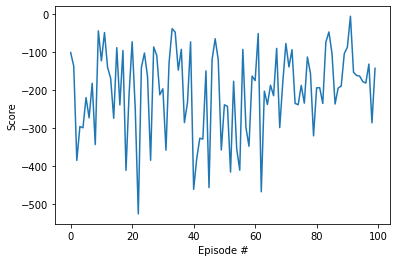

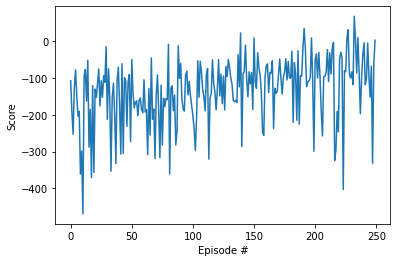

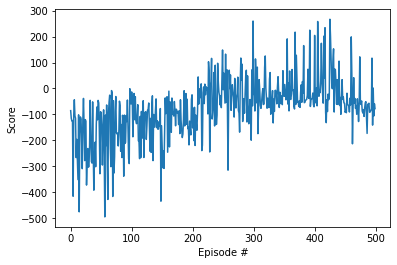

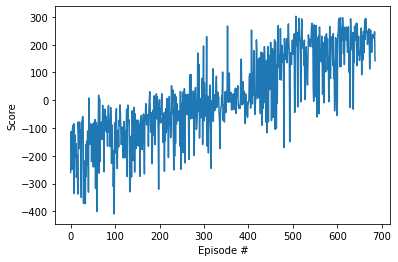

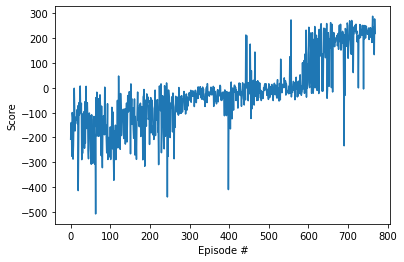

In [14]:
train_dif_episode([100, 250, 500, 750, 1000])